# Coding part

## Preparation (libraries, data and data exploration)

In [ ]:
# Improt the necessary libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# Load the data into workplace (Pull the data into floder in advance)
x_data = np.load('x_data_273.npy')
y_data = np.load('y_data_273.npy')
x_test = np.load('x_test_273.npy')

In [ ]:
# View the data and gain a quick understanding of data
x_data.shape

(32000, 28, 56)

In [ ]:
y_data

array([8, 6, 5, ..., 6, 1, 1], dtype=uint8)

In [ ]:
# Devide the data into train data and validation data
X_train,X_val,y_train,y_val = train_test_split(x_data,y_data,
                         test_size=0.4,
                         random_state=0)

## Number Switching to double the training data

Because the lable of each input return the biggest number of the data, switching the position of two numbers in the data will not change the result.By doing so, it doubles the training data in hand.

In [ ]:
# Creating new data by switching the position of two numbers in each input.
X_train2 = np.full_like(X_train , 0)
for i in range(0,len(X_train),1):
    A = X_train[i][:,0:28]
    X_train2[i] = np.c_[X_train[i][:,28:56],A]
X_train2.shape

(19200, 28, 56)

In [ ]:
# Combine the new training data with the original training data.
X_train = np.r_[X_train,X_train2]
X_train.shape

(38400, 28, 56)

In [ ]:
# update the label of new training data.
y_train = np.r_[y_train,y_train]
y_train.shape

(38400,)

9

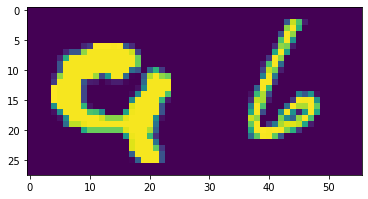

In [ ]:
# check the result
plt.imshow(X_train[65])
y_train[65]

9

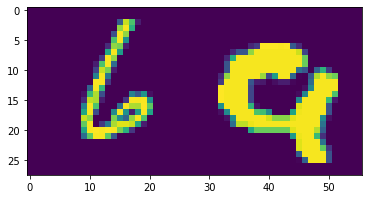

In [ ]:
plt.imshow(X_train[len(X_train2) + 65])
y_train[len(X_train2) + 65]

## Create the Model and feed the data

In [ ]:
# scale 
X_train = X_train.astype('float32')/255
X_train = np.expand_dims(X_train, axis=-1)

In [ ]:
X_val = X_val.astype('float32')/255
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
    ]
)

In [ ]:
x_train = keras.Input(shape=(28, 56, 1))
x = data_augmentation(x_train)
x = layers.Conv2D(32, 2, use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(32, 3, use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(128, 3, use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=128, kernel_size=4, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=4, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=x_train, outputs=outputs)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 56, 1)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 56, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 56, 32)        128       
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 56, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 56, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 56, 32)        9216      
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 56, 32)        128 

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=4,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [ ]:
X_train.shape

(38400, 28, 56, 1)

In [ ]:
history = model.fit(X_train,
           y_train,
           epochs=50,
           batch_size=512,
           callbacks=callbacks_list,
           validation_data=(X_val,y_val))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


75/75 [==============================] - 11s 130ms/step - loss: 1.8732 - accuracy: 0.3019 - val_loss: 2.2527 - val_accuracy: 0.1488
Epoch 2/50
75/75 [==============================] - 9s 122ms/step - loss: 0.9225 - accuracy: 0.6921 - val_loss: 2.3983 - val_accuracy: 0.0895
Epoch 3/50
75/75 [==============================] - 10s 130ms/step - loss: 0.5186 - accuracy: 0.8336 - val_loss: 2.1022 - val_accuracy: 0.2002
Epoch 4/50
75/75 [==============================] - 10s 129ms/step - loss: 0.3804 - accuracy: 0.8834 - val_loss: 1.3133 - val_accuracy: 0.5725
Epoch 5/50
75/75 [==============================] - 9s 122ms/step - loss: 0.3055 - accuracy: 0.9059 - val_loss: 0.7026 - val_accuracy: 0.8106
Epoch 6/50
75/75 [==============================] - 10s 129ms/step - loss: 0.2544 - accuracy: 0.9215 - val_loss: 0.6323 - val_accuracy: 0.8002
Epoch 7/50
75/75 [==============================] - 9s 122ms/step - loss: 0.2259 - accuracy: 0.9312 - val_loss: 0.2902 - val_accuracy: 0.9055
Epoch 8/50
75

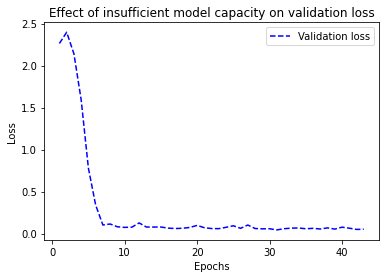

In [ ]:
val_loss = history.history["val_loss"]
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model2 = keras.models.load_model("checkpoint_path.keras")

In [ ]:
# scale the test data and predict the result
x_test3 = x_test.astype('float32')/255
x_test3 = np.expand_dims(x_test3, axis=-1)

y_predict = model2.predict(x_test3)

In [ ]:
df_predict = pd.DataFrame(y_predict, columns=['solution_' + str(i) for i in range(10)])
df_predict.head()
df_predict.index.rename('Id', inplace=True)
df_predict.to_csv('df_predictions.csv')

In [ ]:
np.argmax(y_predict[65])

7

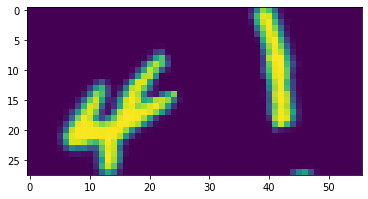

In [ ]:
plt.imshow(x_test[65])

# Journal

**Submission 1&2 :**

Try the code in benchmark1 by applying the FNN and CNN model, which turned out to be high loss rate (5.3 and 3.1).

**Submission 3&4 ：**

During the breakout room exercise, we improved the model by changing the output layer's activation function from "sigmod" to "softmax" to better solve the multiple-type classification problem.
As a result, the score improved from 3.11 to 0.39. 

Futhermore, we applyed some advanced techniques:

1. Insert augmentation layer by adding random rotation to the input. (Because we noticed there is rotation in the test data.)

2. Use callback to find the best epoch numbers to construct the model.

3. Use early stopping.

In the end, the result improved to 0.059.


**Submission 4 :**

Xiaotong Xu changed the optimizor to "adam" and rerun the programme but we found a supprisingly bad result.(The score turned to 1.67)


**Submission 5 :**

Weihang Fu rerun the same programme shared by Jiehao Wan after the breakroom but we still found a rather significant difference in the score compared with the one in Submission 4. 

**Submission 6 :**

Jiehao Wan found that switching the position of two numbers in each traing data will not change the output. Therefore we used number switching technique to double the traing data and trained the model.

The score of this submission is 1.80. (Not ideal)

** Submission 7 to 15 :**

To improve the result, we did the following modification:

1. Add more convolution layers and increase the neurons in some layers. 

2. Change the learning rate


3. Add the contrast function in the augumentation layer


In the end, the score spread from 0.25 to 4.1, which was not as good as we expect.





**Submission 16 :**

Jiehao Wan found he mistakenly delete a part of code which was originally used to scale the test data after the Submmision 4 . This contributed to the unsatisfactory result before.

We fixed the bug and applyed the newest model architecture we had bulit before.

The result improved from 0.059 to 0.018.

**Submission 17：**

We used "Numbers Switching Technique" again and the result improved from 0.018 to 0.016.


**Submission 18 :**

By changing the filter size of last Convolution layer form 2 to 3, the result improved to 0.009

**Submission 19 :**

We did the following modification:

1. Let the learning rate of the optimizer decacy along with the number of iterations.
2. Increase one more convolotuion layer in the model.

The score improved to 0.00895. 

**Submission 20 to 24 :**

Based on the model before, we did the following modification:

1. Adjust the size of fliters in the convolution layers.
2. Use the batch normalization in the convolution layers.
3. Adjust the decacy rate of adam optimizer.

The score fluctuated around 0.01.